In [21]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import plotly.express as px

In [3]:
# Load the dataset (replace 'Online Retail.xlsx' with your dataset file)
data = pd.read_excel('Online Retail.xlsx')

# Display the first few rows
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Check basic information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# Check for missing values
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Statistical summary of the data
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
# Drop rows with missing CustomerID as it's crucial for segmentation
data = data.dropna(subset=['CustomerID'])

In [11]:
# Remove invalid entries (negative or zero Quantity or UnitPrice)
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

In [12]:
# Drop duplicates if any
data = data.drop_duplicates()

In [13]:
print("Shape after cleaning:", data.shape)
data.head()

Shape after cleaning: (392692, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [14]:
# Create TotalPrice column
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Aggregate data by CustomerID
customer_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'InvoiceNo': 'nunique'
}).reset_index()

# Rename columns for clarity
customer_data.rename(columns={'InvoiceNo': 'TransactionCount'}, inplace=True)

# Display aggregated data
customer_data.head()

,CustomerID,Quantity,TotalPrice,TransactionCount
0,12346.0,74215,77183.60,1
1,12347.0,2458,4310.00,7
2,12348.0,2341,1797.24,4
3,12349.0,631,1757.55,1
4,12350.0,197,334.40,1


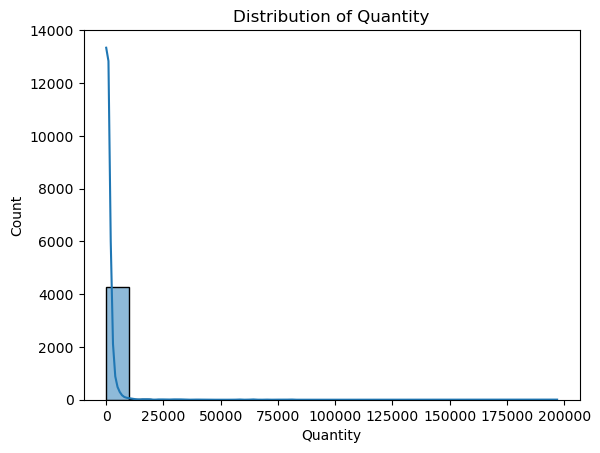

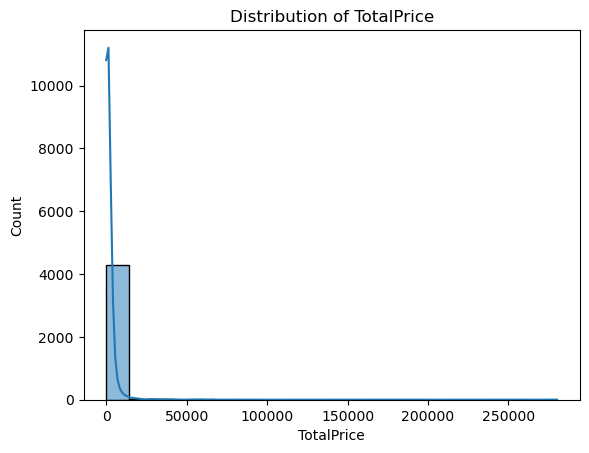

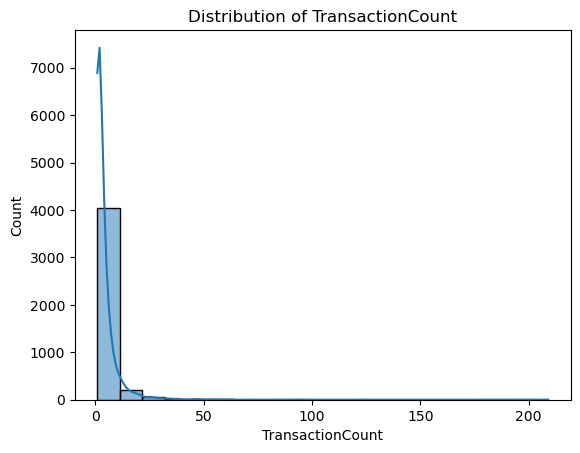

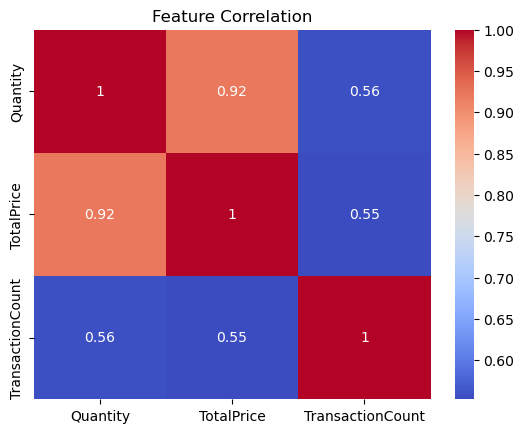

In [15]:
# Visualize distributions of key features
for column in ['Quantity', 'TotalPrice', 'TransactionCount']:
    sns.histplot(customer_data[column], kde=True, bins=20)
    plt.title(f'Distribution of {column}')
    plt.show()

# Check correlation between features
sns.heatmap(customer_data[['Quantity', 'TotalPrice', 'TransactionCount']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

In [16]:
# Select features for clustering
features = customer_data[['Quantity', 'TotalPrice', 'TransactionCount']]

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Display scaled data
print("Scaled Data Sample:")
print(scaled_features[:5])

Scaled Data Sample:
[[14.4808251   8.36301037 -0.4250965 ]
 [ 0.2519028   0.2516989   0.3544168 ]
 [ 0.2287025  -0.02798783 -0.03533985]
 [-0.1103788  -0.03240559 -0.4250965 ]
 [-0.19643804 -0.19081155 -0.4250965 ]]


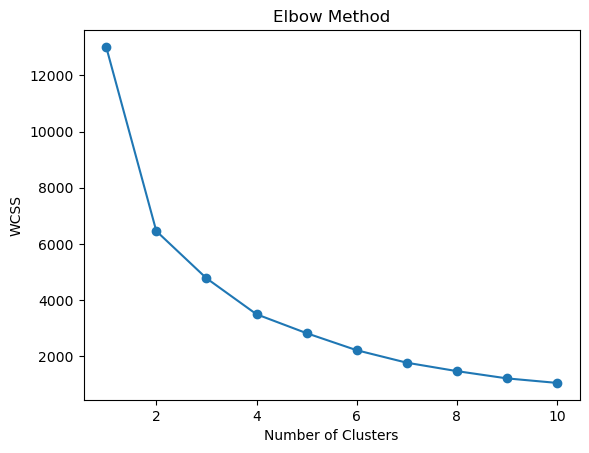

In [18]:
# Determine the optimal number of clusters using the elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)  # Explicitly set n_init to 10
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [19]:
# Fit K-Means with the optimal number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Display cluster labels
print(customer_data['Cluster'].value_counts())
customer_data.head()

C:\Users\dasdi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0    3969
2     339
3      24
1       6
Name: Cluster, dtype: int64


,CustomerID,Quantity,TotalPrice,TransactionCount,Cluster
0,12346.0,74215,77183.60,1,3
1,12347.0,2458,4310.00,7,0
2,12348.0,2341,1797.24,4,0
3,12349.0,631,1757.55,1,0
4,12350.0,197,334.40,1,0


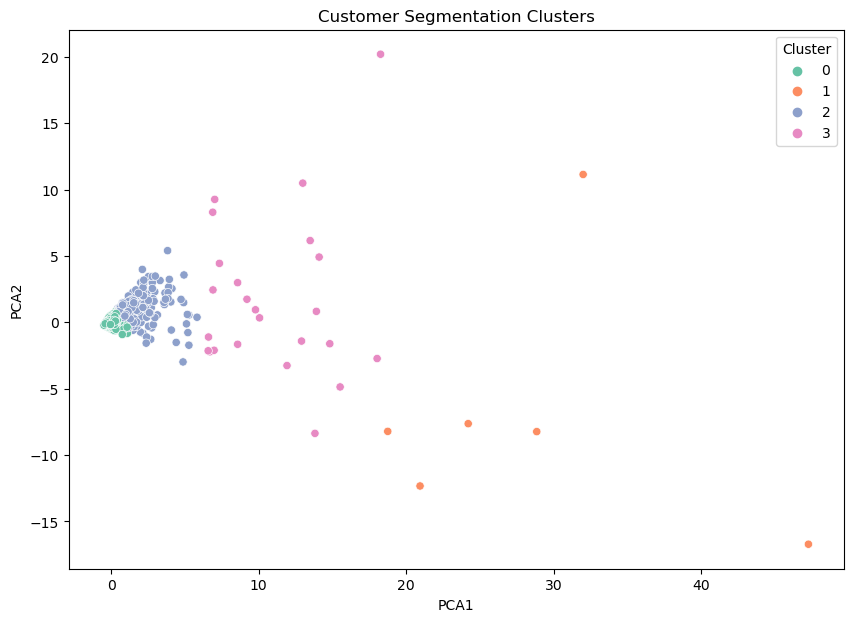

In [22]:
# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Add PCA components to the dataframe
customer_data['PCA1'] = pca_features[:, 0]
customer_data['PCA2'] = pca_features[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=customer_data, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Customer Segmentation Clusters')
plt.show()

In [23]:
# Analyze cluster characteristics
cluster_analysis = customer_data.groupby('Cluster').mean()
print(cluster_analysis)

           CustomerID      Quantity     TotalPrice  TransactionCount  \
Cluster                                                                
0        15307.289997    587.949861     983.232294          2.818342   
1        15661.666667  94937.166667  195225.385000         67.166667   
2        15233.327434   4187.731563    7597.370826         16.418879   
3        15019.500000  34548.541667   51579.120833         57.375000   

              PCA1      PCA2  
Cluster                       
0        -0.239556 -0.080533  
1        28.663112 -6.996622  
2         1.527824  0.943932  
3        10.870348  1.734182  
